# Setup

In [1]:
#  importing important packages while checking versions
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os
import pandas as pd
from collections import Counter

%matplotlib inline
import matplotlib as matpl
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.gridspec as gspec


# TASK 1: DATASET SELECTION

DataSet Selected: MOBILE MONEY FRAUD DATA SET

Reason:

Due to lack of enough research out there on mobile money transaction (mmt) frauds and increase of usage of MMT services across Africa and all over the world and my work as developer for mmt service generator for the last 7 years, I have decided to select this data set in this protfolio.

This Dataset is taken from Edgar Lopez-Rojas who used PAYSIM to generate synthetic dataset due to the private nature of financial transactions. According to Lopez this synthatic dtaset generated by PAYSIM resambles real transactions  extracted from one month of financial logs from Mobile Money Service implemented in an African Country. 

This dataset is downloaded from kaggle, please flow the link: https://www.kaggle.com/ealaxi/paysim1 to get more details of the data set


In [2]:
# The Data is uploaded to Notebook in csv file, 
# we will store it in dataFrame (transactions) using pandas read_csv method
# in this Nootebook we will be analysing Test Data generated for credit card fraud.
# This Data is downloded from kaggle from this link: https://www.kaggle.com/ealaxi/paysim1

# Loading config files
import json
with open('config.json', 'r') as f:
    config = json.load(f)

# Loading datasets using pandas to variable 'transactions'
transactions = pd.read_csv(config['Training_Dataset'])
# Displaying first five(5) transactions loaded
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


DATASET Description:

As we can see above Dataset has 9 input attributes and one class attribute, the last attribute 'isFlaggedFraud' just mentions wether given transaction is flagged as a fraud on the existing fraud detection system of the service provider.

Below is the description of what each attribute means:
| Attribute Name    | Description |
| --------------    | ----------- |
| step | maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).|
| type | CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.|
| amount | amount of the transaction in local currency. |
| nameOrig | customer who started the transaction |
| oldbalanceOrg | initial balance before the transaction |
| newbalanceOrig | new balance after the transaction |
| nameDest | customer who is the recipient of the transaction |
| oldbalanceDest | initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants). |
| newbalanceDest | new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants). |
| isFraud | This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. |
| isFlaggedFraud | The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction. | 

NOTE:

As you can see from above we have 10 fearure attributes and one class attribute, as 'isFlaggedFraud' shows how much existing algorithm is flagging fraud transactions as fraud, in below cell we compare how much is it flagged as fraud and how is an actual fraud.

IS FRAUD:  8213
IS FLAGGED FRAUD:  16


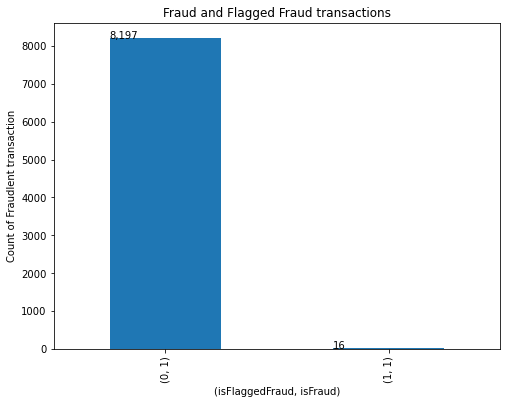

In [3]:

isFraud =  transactions['isFraud'].value_counts()[1]
isFlaggedFraud =  transactions["isFlaggedFraud"].value_counts()[1]
print("IS FRAUD: ", isFraud)
print("IS FLAGGED FRAUD: ", isFlaggedFraud)

fraud = transactions[transactions["isFraud"] == 1]

ax = fraud.groupby(['isFlaggedFraud','isFraud']).size().plot(kind='bar',figsize=(8, 6))
ax.set_title("Fraud and Flagged Fraud transactions")
ax.set_xlabel("(isFlaggedFraud, isFraud)")
ax.set_ylabel("Count of Fraudlent transaction")
plt.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

Summary:
According to chart above, only 16 out of 8,213 fraud transactions was detected by existing algorithm, this requires a model that will do better in detecting frauds in the system.


Checking if we have any missing data with given dataset

In [4]:
print("Missing Data count: ", len(transactions[transactions.isnull().any(axis=1)].head()))

Missing Data count:  0


Below cell will have a method that we will be using along this notebook, will shows class distribution of given dataset

In [5]:
def classDistribution():
    classAttr = transactions.values[:,-1]
    counter = Counter(classAttr)
    for cl,count in counter.items():
	    percent = count / len(classAttr) * 100
	    print('Class=%d, Instances=%d, Percentage=%.3f%%' % (cl, count, percent))


# TASK 1: Data Analysis And Preprocessing
This section we will analayse features to see which of these features has an impact on on the class attribute

In [6]:
# as we no longer need isFlaggedFraud feature, we will remove it from our dataset
transactions = transactions.drop("isFlaggedFraud", axis=1)

First Attribute we have is step, which is time of transaction mapped to hour, according to data set uploader each step maps to 1 hour of real time, as the data set has 744 steps means one month (31 days) of transaction, below we depict the how transactions flunctuate in 24 hours time
for that we first get the first 24 hours of the transaction

Fraudulent Transactions Hist:


Text(0.5, 0, 'Time')

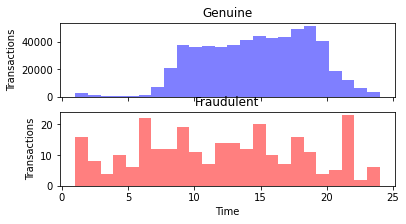

In [7]:

# getting the last five records
transactions['step'].tail()

transactions_in_24hrs = transactions[transactions['step'] < 25]

transactions_in_24hrs.tail()

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, figsize=(6,3))
ax1.hist(transactions_in_24hrs['step'][transactions_in_24hrs['isFraud'] == 0],
         bins=24, color='b', alpha=0.5)
ax1.set_title('Genuine')
ax1.set_ylabel('Transactions')

print('Fraudulent Transactions Hist:')
ax2.hist(transactions_in_24hrs['step'][transactions_in_24hrs['isFraud'] == 1],
         bins=24, color='r', alpha=0.5)
ax2.set_title('Fraudulent')
ax2.set_ylabel('Transactions')

plt.xlabel('Time')
# According the histogram we see relating to time we see transactions
# are more between 5 AM to 8 PM which is normal as its day time


According the histogram we see relating to time we see transactions, there are more between 5 AM to 8 PM which is normal as its day time


<AxesSubplot:xlabel='isFraud', ylabel='step'>

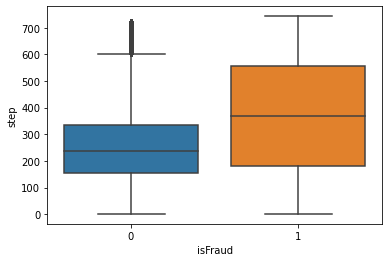

In [8]:
#fig,ax = plt.subplots(1,2,figsize=(10,3))
sns.boxplot(x=transactions.isFraud,y=transactions.step)
#sns.scatterplot(x=data.isFraud,y=data.amount,ax=ax[1])

As you can see from the boxplot above, step feature influences class feature, it is useful to keep it around for the model training

We have around 6 million records which is hard to run ml for limits in computational power, for that reason we want to divide our records into days so that we can pick the day with highest fraud record and analys that, to the end of this notebook.

For that reason, we will introduce new column 'day' which will have values of days totaling to 31 days

In [9]:
transactions['day'] = [int((hour / 24)+1) for hour in transactions.step ]
transactions.day.tail()

6362615    31
6362616    31
6362617    31
6362618    31
6362619    31
Name: day, dtype: int64

On the below cell, we group transactions by step and visualize Fraud/Genuine graph to see how its distributes, for visualization reasons, we first convert days into weeks and visualize days of each week

In [10]:
transactions['week'] = [int((day / 7)+1) for day in transactions.day ]

def drawBarForComparison(data, title):
    ax1 = data.groupby(['day', 'isFraud']).size().plot(kind='bar',figsize=(6, 8), color='blue')
    #ax1.bar(data.groupby(['day', 'isFraud']).size(), color='blue')
    ax1.set_title(title)
    ax1.set_xlabel("(Day, isFraud)")
    ax1.set_ylabel("Count of transaction")
    plt.ticklabel_format(style='plain', axis='y')

    for p in ax.patches:
        ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

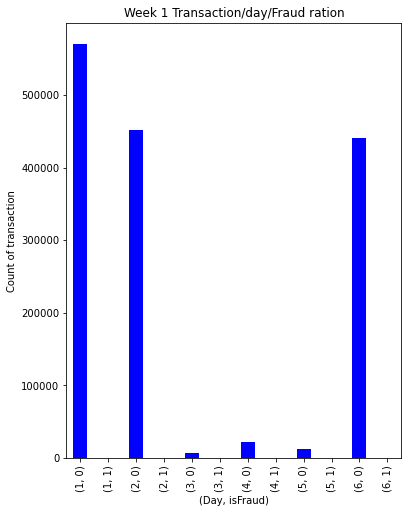

In [11]:
#fig,ax = plt.subplots(3,2, figsize=(10,3))
transactions_week_1 = transactions[transactions['week'] == 1]
drawBarForComparison(transactions_week_1, "Week 1 Transaction/day/Fraud ration")

For week 1, number of fraud transactions varied from 230 to 306 transaction, day 3 had 6,443 transactions only, surprising lowest number of transaction in that week with highest number of frauds around 306 transactions which come to 4% of that days transactions were fraud that is high on this dataset

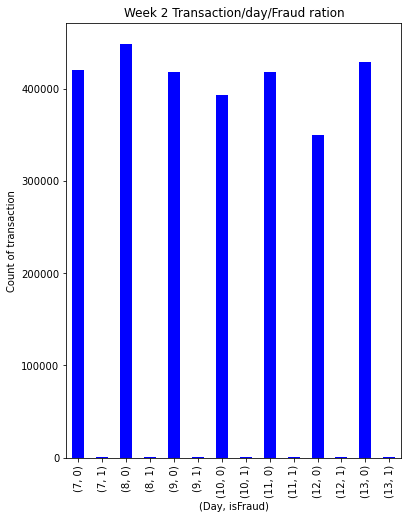

In [12]:
transactions_week_2 = transactions[transactions['week'] == 2]
drawBarForComparison(transactions_week_2, "Week 2 Transaction/day/Fraud ration")

For week 2, Fraudelent transactions were also between 242 to 296 only , getting day 12 the highest number of fraudlent transaction whic accumalated to 0.08% of the transactions that day were fraudlent but still lower than day 3 if for genuine/fraud ration 

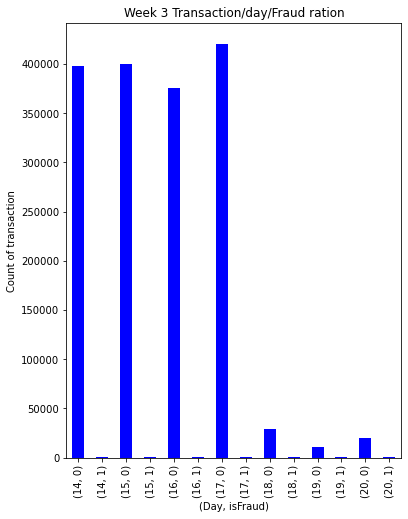

In [13]:
transactions_week_3 = transactions[transactions['week'] == 3]
drawBarForComparison(transactions_week_3, "Week 3 Transaction/day/Fraud ration")

Week 3 was no different than previous weeks were fraud transactions varies from 238 to 316, day 17 had highest number of frauds but genuine/fraud ration puts to 0.07% of that days transaction were fraud which very much lower of that of day 3

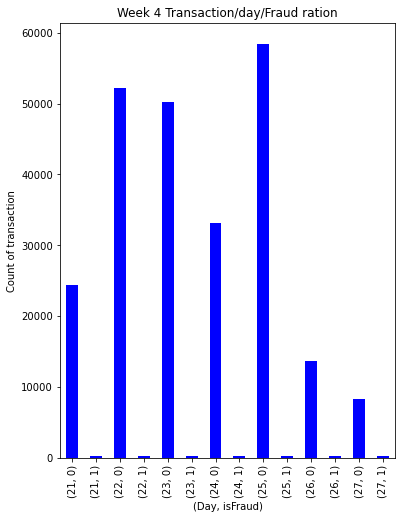

In [14]:
transactions_week_4 = transactions[transactions['week'] == 4]
drawBarForComparison(transactions_week_4, "Week 4 Transaction/day/Fraud ration")

For week 4, fraud transaction occured was between 220 to 280  which low per day comparing to days 3,12 and 17 so we will not anyalize this week further

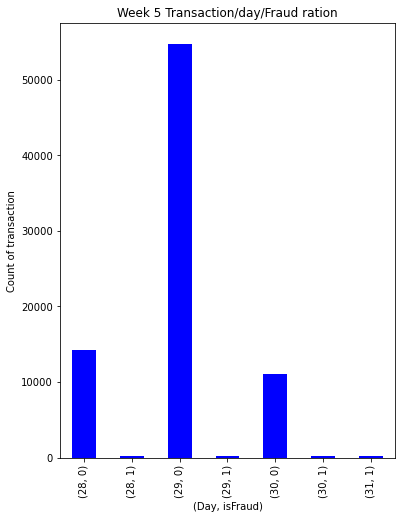

In [15]:
transactions_week_5 = transactions[transactions['week'] == 5]
drawBarForComparison(transactions_week_5, "Week 5 Transaction/day/Fraud ration")

CONCLUSION

Step, have relevence t our dataset, removing it may cause loss of information, so we will keep this feature around, but newly added columns of week and day seem to no have relevance at this monet because data distribution of fraud and genuine transactions flow no secif rule that could enhance the fraud detection, so we will be removing them from our dataset

In [16]:
transactions = transactions.drop('week', axis=1)
transactions = transactions.drop('day', axis=1)
transactions

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


Going to the second attribute in our dataset, 'type', this is of five catagories: CASH_IN, CASH_OUT, DEBIT, PAYMENT and TRANSFER, let us plot transaction grouped by type to see how much of each type is executed during the 31 days period

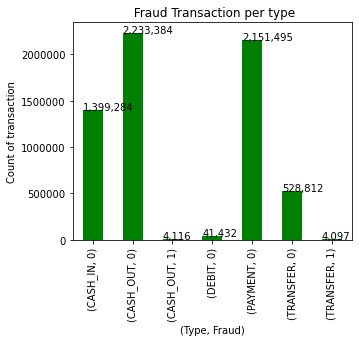

In [17]:
ax = transactions.groupby(['type', 'isFraud']).size().plot(kind='bar',figsize=(5, 4), color='green')
ax.set_title(" Fraud Transaction per type")
ax.set_xlabel("(Type, Fraud)")
ax.set_ylabel("Count of transaction")
plt.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

Note:
1. Types: CASH_OUT and TRANSFER seem to be the ones with fraudlent transaction
2. Around 4,116 cashout transactions and 4,097 transactions are considered fraud
3. Total number of frauds is around 8,213, that is 100% of the frauds are of Type: CASH_OUT and TRANSFER 

AS only these two types have any fraudlent data, we will drop all other transactions, this will help us reduce the data as well, after that we will convert remaining types to numeric value for our model processing 

In [18]:
#print(transactions.shape)
transactions = transactions.drop(transactions[(transactions.type != 'CASH_OUT') & (transactions.type != 'TRANSFER')].index)
# Checking our class distribution
classDistribution()

Class=1, Instances=8213, Percentage=0.296%
Class=0, Instances=2762196, Percentage=99.704%


This will reduce our dataset to around 2.7 milion records, now we have only two types of transactions we can use ordinal encoder to encode it to 0 and 1

In [19]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
transactions["type"] = encoder.fit_transform(transactions[["type"]])
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,1.0,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1
3,1,0.0,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1
15,1,0.0,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0
19,1,1.0,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0
24,1,1.0,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0


Next we will draw all remaining features and their influence to fraud detection 

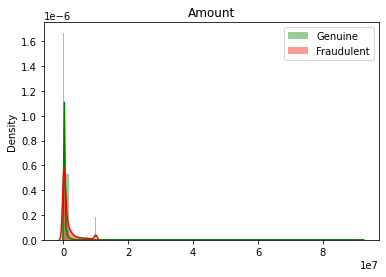

min    0.000000e+00
max    9.244552e+07
std    8.877897e+05
Name: amount, dtype: float64
highest fraudlent amount is:  10000000.0


In [20]:
gs = gspec.GridSpec(1,1)
plt.figure(figsize=(6,4))
ax5 = plt.subplot(gs[0])
sns.distplot(transactions.amount[transactions.isFraud == 0], bins=50, color='g', label='Genuine')
sns.distplot(transactions.amount[transactions.isFraud == 1], bins=50, color='r', label='Fraudulent')
ax5.set_xlabel('')
ax5.set_title(str('Amount'))
plt.legend(loc='upper right')

plt.show()

print(transactions.describe().loc[['min','max','std'], 'amount'])
transactions_max_fraud = transactions[transactions.isFraud == 1].amount.max()
print("highest fraudlent amount is: ", transactions_max_fraud)

Amount seems to be having values between 0 to 92 million in local currancy, highest amount that is flagged fraud is 10 million, so large amount doesnt neccesary mean fraudlent transaction, we will keep amount feature as its and move one to other features

Remaining features are nameOrig, oldbalanceOrg,	newbalanceOrig,	nameDest, oldbalanceDest, newbalanceDest.
We will drop nameOrig and nameDest as they just metadata that doesnt hold much information that could have an impact on fraud detection

In [21]:
transactions = transactions.drop(['nameOrig', 'nameDest'], axis=1)
transactions.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,1.0,181.00,181.0,0.0,0.0,0.00,1
3,1,0.0,181.00,181.0,0.0,21182.0,0.00,1
15,1,0.0,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,1.0,215310.30,705.0,0.0,22425.0,0.00,0
24,1,1.0,311685.89,10835.0,0.0,6267.0,2719172.89,0


Let us analayse now balances both sender and receiver, first let us devide our dataset by type, this is because for type = CASHOUT transactions receiver balance is irrelevant as cash is withdraw from senders account, but for type=TRANSFER both sender and receiver balances are effected.

so after encoding our nominal type, it converted 1= TRANSFER and 0=CASH_OUT

In [22]:
transfer_transactions = transactions[transactions.type == 1.0]
cashout_transactions = transactions[transactions.type == 0.0]

print("transfer shape: ", transfer_transactions.shape)
print("cashout shape: ", cashout_transactions.shape)

transfer shape:  (532909, 8)
cashout shape:  (2237500, 8)


Now that we have two different datasets, we will look into transfer_transactions dataset and validate if there are any distrubances in balances compared to transfer amount

In [23]:
# Checking sender account for both types [TRANSFER, CASHOUT] 
senderBalanceError = sum(transactions["oldbalanceOrg"] - transactions["amount"] != transactions["newbalanceOrig"])
print("Percentage of balance errors in the sender account: ", 100*round(senderBalanceError/len(transactions),2))

# Checking receiver account for only type = TRANSFER
ReceiverBalanceError = sum(transfer_transactions["newbalanceDest"] + transfer_transactions["amount"] != transfer_transactions["newbalanceDest"])
print("Percentage of balance errors in the receiver account: ", 100*round(ReceiverBalanceError/len(transactions),2))

# number of  amounts with negative numbers in balances and amount column
count_negative_values = sum(n < 0 for n in transactions[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]].values.flatten())
print("number of with negative amounts: ", count_negative_values)
   

Percentage of balance errors in the sender account:  94.0
Percentage of balance errors in the receiver account:  19.0
number of with negative amounts:  0


According to previous results, we have differencies in both sender and receiver balances that are suspecious, some of these transactions are fraud, we have also checked if there are negative values in amounts and balances and found 0 -ve values.

let us create new attributes 'senderBalanceDifference' and 'receiverBalanceDifferenc' then we will check percentage of frauds with eror balances

In [24]:
# storing balance difference for the sender
senderBalanceDifference = transactions.newbalanceOrig + transactions.amount - transactions.oldbalanceOrg
transactions.insert(loc=5, column="senderBalanceDifference", value=senderBalanceDifference)

# storing balance difference for the receiver
receiverBalanceDifference = transactions.oldbalanceDest + transactions.amount - transactions.newbalanceDest
transactions.insert(loc=8, column="receiverBalanceDifference", value=receiverBalanceDifference)

fraudTransactions = transactions[transactions.isFraud == 1]
genuineTransactions = transactions[transactions.isFraud == 0]

percent_fraud_err_sender = len(fraudTransactions[fraudTransactions.senderBalanceDifference > 0]) / len(fraudTransactions)
percent_fraud_err_receiver = len(fraudTransactions[fraudTransactions.receiverBalanceDifference > 0]) / len(fraudTransactions)

percent_genuine_err_sender = len(genuineTransactions[genuineTransactions.senderBalanceDifference > 0]) / len(genuineTransactions)
percent_genuine_err_receiver = len(genuineTransactions[genuineTransactions.receiverBalanceDifference > 0]) / len(genuineTransactions)

print("Percentage fraudulent transactions with error in sender balance: ", percent_fraud_err_sender)
print("Percentage of genuine transactions with error in sender balance: ", percent_genuine_err_sender)
print("Percentage of fraudulent transactions with error in receiver balance : ", percent_fraud_err_receiver)
print("Percentage of genuine transactions with error in receiver balance: ", percent_genuine_err_receiver) 


Percentage fraudulent transactions with error in sender balance:  0.006331425788384269
Percentage of genuine transactions with error in sender balance:  0.9067180605576143
Percentage of fraudulent transactions with error in receiver balance :  0.5712894192134421
Percentage of genuine transactions with error in receiver balance:  0.19744942067832985


There are errors in balances for both fraud and genuine transactions, there is around 49% of transactions that has error in receiver balance and considered fraud, we will keep these new attributes as they might help improve the fraud detection

# Data Set Balancing

As you have noticed through out our analysis, given dataset is hugely imbalanced and needs to be balanced, let us visualize how much given dataset is skewed in favour of one of the classes

Text(0, 0.5, '')

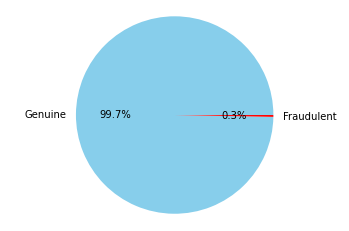

In [25]:
fig, ax = plt.subplots(1,1)
ax.pie(transactions['isFraud'].value_counts(),
       autopct= '%1.1f%%', labels=['Genuine', 'Fraudulent'],
       colors = ['skyblue', 'r'])
plt.axis('equal')
plt.ylabel('')


Observe that 99.7% of given dataset is of class 0, and only 0.3% is of class 1, this means we will need to balance our dataset so that classifiers wont favour one class over the other

For balancing, we will be using sklean model selection both RandomUnderSample and SMOTE to combines, to avoid both losing valuable information or overfitting 

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
def balanceDataSet(X, y):
    over = SMOTE(sampling_strategy=0.3)

    # fit and apply the transform
    X, y = over.fit_resample(X, y)

    # summarize class distribution
    #print(Counter(y))

    # define undersampling strategy
    under = RandomUnderSampler()

    # fit and apply the transform
    X, y = under.fit_resample(X, y)

    # summarize class distribution
    #print(Counter(y))


    #print("Resampled shape of X: ", X.shape)
    #print("Resampled shape of Y: ", y.shape)
    value_counts = Counter(y)
    #print(value_counts)

    return X,y


Counter({0: 2762196, 1: 828658})
Counter({0: 828658, 1: 828658})
Counter({0: 828658, 1: 828658})


Text(0, 0.5, '')

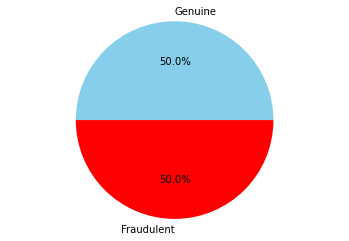

In [27]:
X = transactions.iloc[:, :-1]
y = transactions['isFraud']

X,y = balanceDataSet(X, y)
fig, ax = plt.subplots(1,1)
ax.pie(y.value_counts(),
       autopct= '%1.1f%%', labels=['Genuine', 'Fraudulent'],
       colors = ['skyblue', 'r'])
plt.axis('equal')
plt.ylabel('')


Now that we have balanced our data set let us get corelation among the attributes

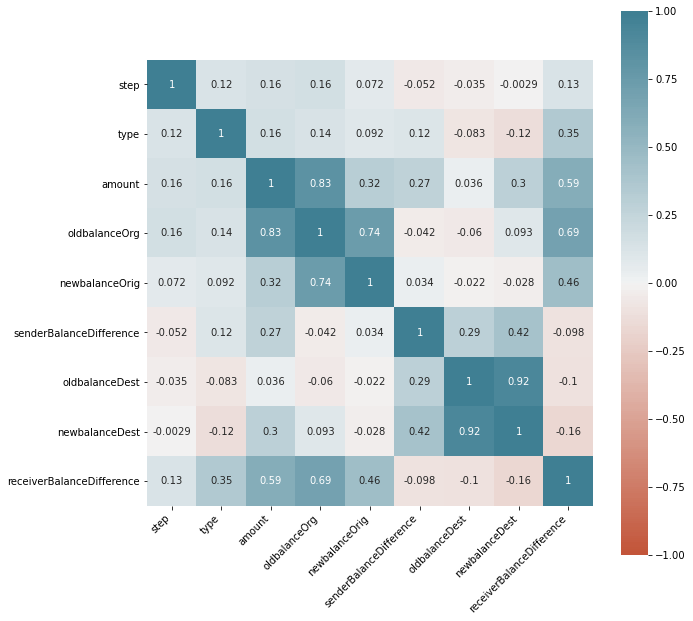

In [28]:
import seaborn as sns
corrMatrix = X.corr()
plt.figure(figsize=(10,10))

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

From the corelation heatmap above we can see that that both oldBalanceDest is highly corelated with newBalanceDest of a rate 0.93,  we will be using only one attribute to reduce attribute dimention 

In [29]:
# droping 'oldbalanceDest' as it has coreation of 0.93 with 'newbalanceDest'
transactions = transactions.drop("oldbalanceDest", axis=1)

# Conclusion on Data Analysis and Preprocessing
To summarize the analysis and data preprocessing, I come to conclusion of the flowing:
1. Dataset has no missing value
2. Dnly 16 out of 8213 frauds were detected by existing algorithm hence more regist ML algorithm is required
3. Grouping Dataset to days or weeks derived from 'step' attribute doesnt show any pattern so attribute was kept as its and no more features were derived from it, but 'step' attribute has an influence on the class detection, hence was kept.
4. 'type' attribute of values ('CAHS_OUT' and 'TRANSFER') are the only types with fraud data, remaing types was discarded to reduce data count as this had no caused any credibe information loss.
5. type then with only two values was converted to numeric value using ordinalEncoder.
6. There was high describances in balances both sender and receiver, I produced two more features out of these discribances.
7. Dataset was highly imbalanced, I combination of both oversampling (SMOTE) and undersampling (RandomUndersampling) to produce balanced data.
8. using corelation heatmap, we have observed high corelation between oldbalanceDest and newBalanceDest so we will be using only one of these to reduce attribute dimension.

# TASK 2: Naïve Bayes Classifier
Now that we have preprocessed given dataset, we will run Naive Bayes Classifier on it to see how good classifer will perform on the given dataset.

To avoid overfitting, we will first divide our unbalanced dataset into train and test then balance them seperately

Now that we have our unbalanced dataset, we will balance both train and test sets seperately to avoid data leakage

I will train Naive Bayes Classifier now with balanced train data using sklean, there are three models of naive bayes; Gussian, Multinomial and Bernoulli, we will use GussianNB as the data we have is contineous data

An easy function that will split dataset then balance them

In [50]:
from sklearn.model_selection import train_test_split
def splitdata_and_balance(dataset):
    X = dataset.iloc[:, :-1]
    y = dataset.isFraud.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y, shuffle=True)

    X_train,y_train = balanceDataSet(X_train, y_train)
    X_test,y_test = balanceDataSet(X_test, y_test)

    return X_train, X_test, y_train, y_test


An easy method that will run naive bayes classifier on given data set

In [51]:

import helper
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,confusion_matrix
def runNaiveBayesClassifier(dataset):
    X_train, X_test, y_train, y_test = splitdata_and_balance(dataset)
    print("*"*70)
    print("Gussion Naive Bayes Classifier\n")
    nb_clf = GaussianNB()
    nb_clf.fit(X_train, y_train)

    # predicting data
    y_pred = nb_clf.predict(X_test)
    y_pred = np.round(y_pred)
    #print(y_pred)

    success_rate, error_rate , sensitivity, specificity, tbForm = helper.get_perf_messure(y_test, y_pred)
    print('Success Rate: {0:.2f}%'.format(success_rate* 100))
    print('Error Rate: {0:.2f}%'.format(error_rate * 100))
    print('Sensitivity: {0:.2f}%'.format(sensitivity * 100))
    print('Specificity: {0:.2f}%'.format(specificity * 100))
    print(tbForm)

    print("\n****** Scores ****\n")
    print(classification_report(y_test, y_pred))

    helper.show_conf_mattr(y_test, y_pred, nb_clf, X_test)
    print("*"*70)

**********************************************************************
Gussion Naive Bayes Classifier

Success Rate: 72.54%
Error Rate: 27.46%
Sensitivity: 47.02%
Specificity: 98.07%
+------------+-------------+-------------+
|            | Predicted Y | Predicted N |
+------------+-------------+-------------+
| Actually Y |    128572   |    144885   |
| Actually N |     5286    |    268171   |
+------------+-------------+-------------+

****** Scores ****

              precision    recall  f1-score   support

           0       0.65      0.98      0.78    273457
           1       0.96      0.47      0.63    273457

    accuracy                           0.73    546914
   macro avg       0.80      0.73      0.71    546914
weighted avg       0.80      0.73      0.71    546914



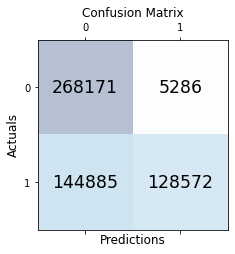

**********************************************************************


In [55]:
runNaiveBayesClassifier(transactions)

This is method that draws heatmap on given dataset

In [33]:
import seaborn as sns
def cor_heatmap(dataset, title):
    corrMatrix = dataset.corr()
    plt.figure(figsize=(8,8))
    top_corr_features = corrMatrix.index
    ax = sns.heatmap(
        corrMatrix, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True
    )
    ax.set_title(title)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right');


# TASK 3: Diving Data Set By Class and Finding corelation between features
We have 8 input feature and 2 classes, we will divide our dataset first by class and draw heatmap of the relations

First we will draw heatmap for class 0 (genuine)

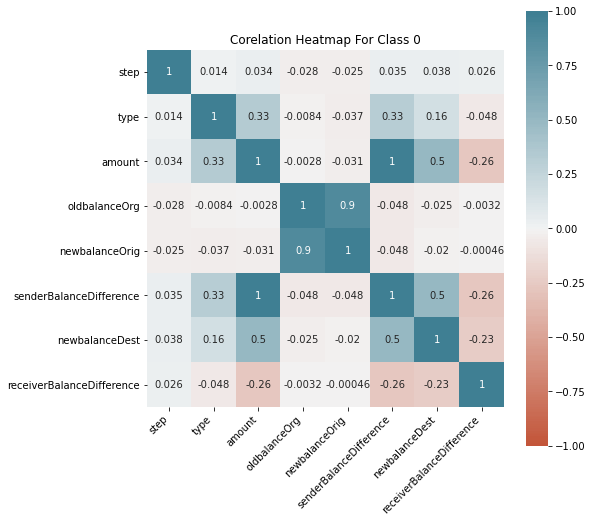

In [34]:
genuineClass = transactions[transactions['isFraud'] == 0]
cor_heatmap(genuineClass.iloc[:, :-1], 'Corelation Heatmap For Class 0')

We can notice that for class 0 features oldbalanceOrg and newbalanceOrig have corelation of 0.9 while second to them amount and newbalanceDest have corelation of 0.5, hence, we can conclude that for class 0:
1. amount
2. oldbalanceOrg
3. newbalanceOrig 
4. newbalanceDest
 
are the top corelating feature in the given dataset

Now Getting Corelation Heatmap for class 1 (fraud)

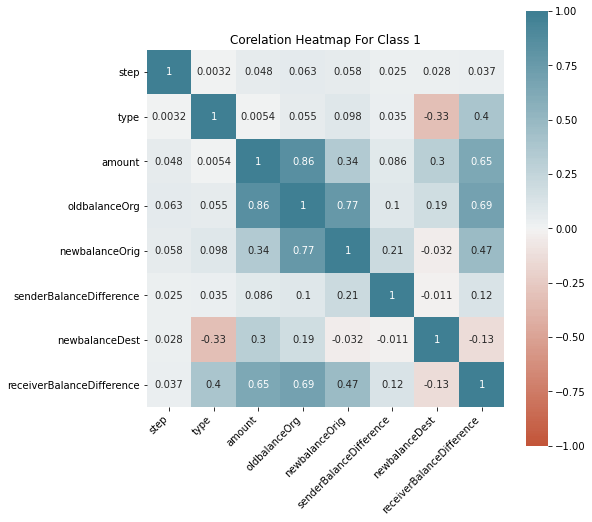

In [35]:
fraudClass = transactions[transactions['isFraud'] == 1]
cor_heatmap(fraudClass.iloc[:, :-1], 'Corelation Heatmap For Class 1')

For class 1, we can see that amount, oldbalanceOrg, newbalanceOrig, receiverBalanceDifference are most corelation feature to this particular class 

We will divide given dataset into three datasets.
1. First dataset will have only 2 features 1 from each class: oldbalanceOrg, newbalanceOrig
2. Second dataset will have 4 features, two from each class: oldbalanceOrg, newBalanceOrig, newbalanceDest, amount.
3. Third dataset will contain 6 features 3 from each class: oldbalanceOrg, newBalanceOrig, newbalanceDest, amount, receiverBalanceDifference, type

**********************************************************************
Gussion Naive Bayes Classifier

Success Rate: 71.91%
Error Rate: 28.09%
Sensitivity: 45.61%
Specificity: 98.20%
+------------+-------------+-------------+
|            | Predicted Y | Predicted N |
+------------+-------------+-------------+
| Actually Y |    124717   |    148740   |
| Actually N |     4911    |    268546   |
+------------+-------------+-------------+

****** Scores ****

              precision    recall  f1-score   support

           0       0.64      0.98      0.78    273457
           1       0.96      0.46      0.62    273457

    accuracy                           0.72    546914
   macro avg       0.80      0.72      0.70    546914
weighted avg       0.80      0.72      0.70    546914



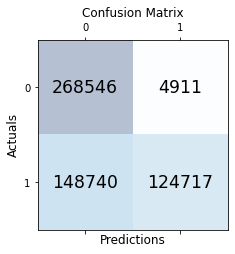

**********************************************************************


In [56]:
#print(transactions.head())
dataset1 = transactions.filter(['oldbalanceOrg', 'newbalanceOrig', 'isFraud'], axis=1)
runNaiveBayesClassifier(dataset1)

**********************************************************************
Gussion Naive Bayes Classifier

Success Rate: 72.13%
Error Rate: 27.87%
Sensitivity: 46.77%
Specificity: 97.49%
+------------+-------------+-------------+
|            | Predicted Y | Predicted N |
+------------+-------------+-------------+
| Actually Y |    127892   |    145565   |
| Actually N |     6864    |    266593   |
+------------+-------------+-------------+

****** Scores ****

              precision    recall  f1-score   support

           0       0.65      0.97      0.78    273457
           1       0.95      0.47      0.63    273457

    accuracy                           0.72    546914
   macro avg       0.80      0.72      0.70    546914
weighted avg       0.80      0.72      0.70    546914



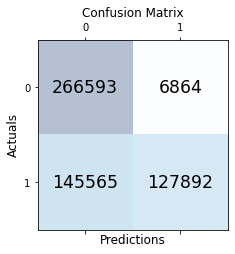

**********************************************************************


In [57]:
dataset2 = transactions.filter(['oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest', 'amount', 'isFraud'], axis=1)
runNaiveBayesClassifier(dataset2)

**********************************************************************
Gussion Naive Bayes Classifier

Success Rate: 70.97%
Error Rate: 29.03%
Sensitivity: 43.97%
Specificity: 97.97%
+------------+-------------+-------------+
|            | Predicted Y | Predicted N |
+------------+-------------+-------------+
| Actually Y |    120229   |    153228   |
| Actually N |     5564    |    267893   |
+------------+-------------+-------------+

****** Scores ****

              precision    recall  f1-score   support

           0       0.64      0.98      0.77    273457
           1       0.96      0.44      0.60    273457

    accuracy                           0.71    546914
   macro avg       0.80      0.71      0.69    546914
weighted avg       0.80      0.71      0.69    546914



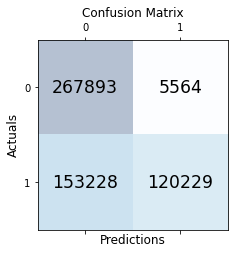

**********************************************************************


In [58]:
dataset3 = transactions.filter(['oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest', 'amount', 'receiverBalanceDifference', 'type', 'isFraud'], axis=1)
runNaiveBayesClassifier(dataset3)

# Conclusion
Comparing performance metrics above we can see that adding some more features to the dataset reduces accuracy which shows some features have more imapct on class detetion than others.

Analysing given datset I come to the below conclusion:
1. Classes are not evenly represented.
2. Running classifier on the imbalanced dataset show classifier is biased towards class 0 which has high distribution showing sometimes as high as 99 but looking percision recall shows it s doing poor on detecting class 1
3. After balancing dataset there was improvement in percision and recall and classifier seem to be doing well with accuracy around 73%
4. by chosing only two feature ('oldbalanceOrg', 'newbalanceOrig') we got 72% accuracy with good percision and recall which shows these two features have more reliable to both of the classes, not using step feature doesnt seem to have any effect on class which makes it least reliable to our classes